# Denoising scRNA-seq using DCA

## scRNA-seq Simulation using Splatter R package and rpy2

In [1]:
# make sure that rpy2 is installed: https://rpy2.bitbucket.io/
%load_ext rpy2.ipython

import warnings
from rpy2.rinterface import RRuntimeWarning

# ignore R warning messages
warnings.filterwarnings("ignore", category=RRuntimeWarning)

### Simulate two groups using Splatter

In [2]:
%%R -o counts -o truecounts -o geneinfo -o cellinfo

# make sure that splatter is installed: https://github.com/Oshlack/splatter
library(splatter)

simulate <- function(nGroups=2, nGenes=200, batchCells=2000, dropout=3)
{
    if (nGroups > 1) method <- 'groups'
    else             method <- 'single'

    group.prob <- rep(1, nGroups) / nGroups

    # new splatter requires dropout.type
    if ('dropout.type' %in% slotNames(newSplatParams())) {
        if (dropout)
            dropout.type <- 'experiment'
        else
            dropout.type <- 'none'
        
        sim <- splatSimulate(group.prob=group.prob, nGenes=nGenes, batchCells=batchCells,
                             dropout.type=dropout.type, method=method,
                             seed=42, dropout.shape=-1, dropout.mid=dropout)

    } else {
        sim <- splatSimulate(group.prob=group.prob, nGenes=nGenes, batchCells=batchCells,
                             dropout.present=!dropout, method=method,
                             seed=42, dropout.shape=-1, dropout.mid=dropout)        
    }

    counts     <- as.data.frame(t(counts(sim)))
    truecounts <- as.data.frame(t(assays(sim)$TrueCounts))

    dropout    <- assays(sim)$Dropout
    mode(dropout) <- 'integer'

    cellinfo   <- as.data.frame(colData(sim))
    geneinfo   <- as.data.frame(rowData(sim))

    list(counts=counts,
         cellinfo=cellinfo,
         geneinfo=geneinfo,
         truecounts=truecounts)
}

sim <- simulate()

counts <- sim$counts
geneinfo <- sim$geneinfo
cellinfo <- sim$cellinfo
truecounts <- sim$truecounts

## Generate AnnData objects and analyze in Scanpy

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy.api as sc
from dca.api import dca

Using TensorFlow backend.


In [4]:
adata = sc.AnnData(counts.values, obs=cellinfo, var=geneinfo)
adata.obs_names = cellinfo.Cell
adata.var_names = geneinfo.Gene
sc.pp.filter_genes(adata, min_counts=1)
adata

AnnData object with n_obs × n_vars = 2000 × 198 
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'n_counts'

In [5]:
adata_true = sc.AnnData(truecounts.values, obs=cellinfo, var=geneinfo)
adata_true.obs_names = cellinfo.Cell
adata_true.var_names = geneinfo.Gene
adata_true = adata_true[:, adata.var_names].copy()
adata_true

AnnData object with n_obs × n_vars = 2000 × 198 
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'n_counts'

In [6]:
sc.pp.normalize_per_cell(adata)
sc.pp.normalize_per_cell(adata_true)

sc.pp.log1p(adata)
sc.pp.log1p(adata_true)

sc.pp.pca(adata)
sc.pp.pca(adata_true)

## Denoise simulated data

In [7]:
%%time

adata_ae = sc.AnnData(counts.values, obs=cellinfo, var=geneinfo)
adata_ae.obs_names = cellinfo.Cell
adata_ae.var_names = geneinfo.Gene

sc.pp.filter_genes(adata_ae, min_counts=1)
dca(adata_ae, threads=1)

sc.pp.normalize_per_cell(adata_ae)
sc.pp.log1p(adata_ae)
sc.pp.pca(adata_ae)

DCA: Successfully preprocessed 198 genes and 2000 cells.
Calculating low dimensional representations...
Calculating reconstructions...
CPU times: user 32.5 s, sys: 365 ms, total: 32.9 s
Wall time: 33.2 s


In [18]:
adata_ae

AnnData object with n_obs × n_vars = 2000 × 198 
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize', 'DCA_split', 'n_counts', 'size_factors'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'n_counts'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## PCA: Simulation with and without dropout effect

... storing 'Batch' as categorical
... storing 'Group' as categorical


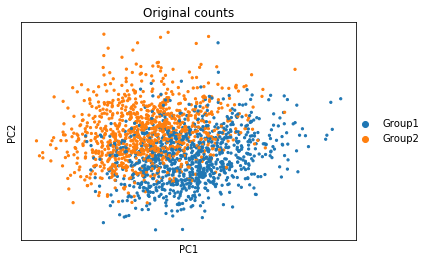

... storing 'Batch' as categorical
... storing 'Group' as categorical


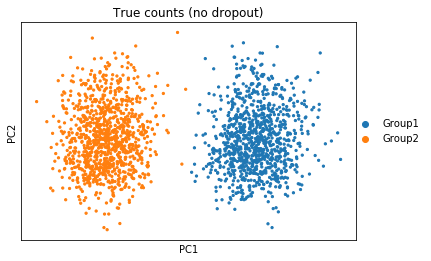

... storing 'Batch' as categorical
... storing 'Group' as categorical


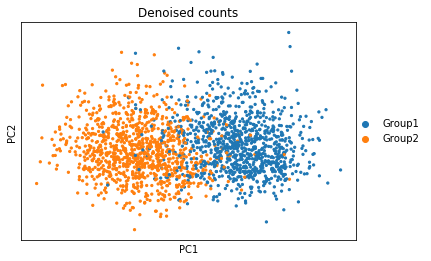

In [19]:
sc.pl.pca_scatter(adata, color='Group', size=20, title='Original counts')
sc.pl.pca_scatter(adata_true, color='Group', size=20, title='True counts (no dropout)')
sc.pl.pca_scatter(adata_ae, color='Group', size=20, title='Denoised counts')

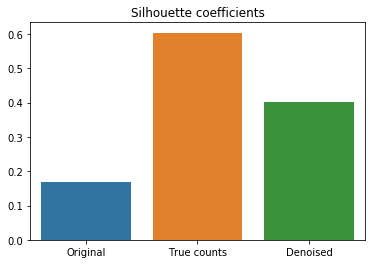

In [20]:
from sklearn.metrics import silhouette_score

sil_orig = silhouette_score(adata.obsm.X_pca[:, :2], adata.obs.Group)
sil_true = silhouette_score(adata_true.obsm.X_pca[:, :2], adata_true.obs.Group)
sil_ae = silhouette_score(adata_ae.obsm.X_pca[:, :2], adata_ae.obs.Group)

sns.barplot(x=['Original', 'True counts', 'Denoised'], 
            y=[sil_orig, sil_true, sil_ae])

plt.title('Silhouette coefficients');

In [ ]:
de_genes = (adata.var.loc[:, 'DEFacGroup1':'DEFacGroup2'].values.sum(1) != 2.0)

sc.pl.clustermap(adata[:, de_genes], 'Group', use_raw=False)
sc.pl.clustermap(adata_ae[:, de_genes], 'Group', use_raw=False)

## Simulate six groups

In [ ]:
%%R -o counts -o geneinfo -o cellinfo -o truecounts

sim <- simulate(nGroups=6, dropout=1)

counts <- sim$counts
geneinfo <- sim$geneinfo
cellinfo <- sim$cellinfo
truecounts <- sim$truecounts

In [ ]:
adata = sc.AnnData(counts.values, obs=cellinfo, var=geneinfo)
adata.obs_names = cellinfo.Cell
adata.var_names = geneinfo.Gene
sc.pp.filter_genes(adata, min_counts=1)

adata_true = sc.AnnData(truecounts.values, obs=cellinfo, var=geneinfo)
adata_true.obs_names = cellinfo.Cell
adata_true.var_names = geneinfo.Gene
adata_true = adata_true[:, adata.var_names].copy()
adata_true

In [ ]:
sc.pp.normalize_per_cell(adata)
sc.pp.normalize_per_cell(adata_true)

sc.pp.log1p(adata)
sc.pp.log1p(adata_true)

sc.pp.pca(adata)
sc.pp.pca(adata_true)

sc.tl.tsne(adata)
sc.tl.tsne(adata_true)

## Denoise simulated data

In [ ]:
%%time

adata_ae = sc.AnnData(counts.values, obs=cellinfo, var=geneinfo)
adata_ae.obs_names = cellinfo.Cell
adata_ae.var_names = geneinfo.Gene

sc.pp.filter_genes(adata_ae, min_counts=1)
dca(adata_ae, threads=1)

sc.pp.normalize_per_cell(adata_ae)
sc.pp.log1p(adata_ae)
sc.tl.tsne(adata_ae)

adata_ae

In [ ]:
sc.pl.tsne(adata, color='Group', size=20, title='Original counts')
sc.pl.tsne(adata_true, color='Group', size=20, title='True counts (no dropout)')
sc.pl.tsne(adata_ae, color='Group', size=20, title='Denoised counts')

In [ ]:
from sklearn.metrics import silhouette_score

sil_orig = silhouette_score(adata.obsm.X_tsne, adata.obs.Group)
sil_true = silhouette_score(adata_true.obsm.X_tsne, adata_true.obs.Group)
sil_ae   = silhouette_score(adata_ae.obsm.X_tsne, adata_ae.obs.Group)

sns.barplot(x=['Original', 'True counts', 'Denoised'], y=[sil_orig, sil_true, sil_ae])
plt.title('Silhouette coefficients');

In [ ]:
adata

In [ ]:
de_genes = (adata.var.loc[:, 'DEFacGroup1':'DEFacGroup6'].values.sum(1) != 6.0)

sc.pl.clustermap(adata[:, de_genes], 'Group', use_raw=False)
sc.pl.clustermap(adata_ae[:, de_genes], 'Group', use_raw=False)